<a href="https://colab.research.google.com/github/isakdiaz/PlantNet_MobileNetV2/blob/main/PlantNet_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Tensorflow and other things

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pprint
import json
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

## Check you are running on a TPU

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

Running on TPU  ['10.123.192.210:8470']


In [ ]:
# Check if running on GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Version Notice
This code assumes you are using tensorflow 2.0 or later and python 3.6 or later

In [ ]:
print("Tensorflow version is " + tf.__version__)
print("Numpy version is " + np.__version__)

Tensorflow version is 2.6.0
Numpy version is 1.19.5


In [ ]:
!pip install git+https://github.com/tensorflow/docs


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-icuu_juo
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-icuu_juo
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0e2abff4864c2895987c866a18db399991e0d7f50_-py3-none-any.whl size=154537 sha256=f8f2aedf9d8412a627b7e4ab0639c960510b128b484a717109f7df71025c931a
  Stored in directory: /tmp/pip-ephem-wheel-cache-bd8bejhw/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Failed to build tensorflow-docs
    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import tensorflow_docs as tdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [ ]:
# Place the plantnet zipped file in a folder called plantnet on your Google Drive directory
# Unzips files from google drive to google colab
!unzip /content/drive/MyDrive/plantnet/plantnet_300K.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantnet_300K/images_test/1363764/36292b7a83e33de3764ed68fc16543bad5bb07db.jpg  
  inflating: plantnet_300K/images_test/1363764/069f465bf6f0757669985a67789f7fb3a8ab41cc.jpg  
  inflating: plantnet_300K/images_test/1363764/18a7639b314d0f10d985f4872b00d7d5c24982a2.jpg  
  inflating: plantnet_300K/images_test/1363764/db66ae8da58d4b5485324a11b6fa7472cfc07bfb.jpg  
  inflating: plantnet_300K/images_test/1363764/e462607ec30224bb48cb7d286a2436275c1bc01e.jpg  
  inflating: plantnet_300K/images_test/1363764/1d16243c59cced47cd91990b2d1b83f5533914be.jpg  
  inflating: plantnet_300K/images_test/1363764/c947804a38eaa45720b7691fa8560416f621eb12.jpg  
  inflating: plantnet_300K/images_test/1363764/357afa09d847115ef35e14164e4cc5011f9d8f35.jpg  
  inflating: plantnet_300K/images_test/1363764/48db1f52629c8c3bae053b111ea6f42e545283fe.jpg  
  inflating: plantnet_300K/images_test/1363764/cd4a080a296494feccf9505a3fa9b73ab0a633df.jpg  
  inflati

In [ ]:
# Check file unzipped properly and is 31GB
!du -hs plantnet_300K/

31G	plantnet_300K/


In [ ]:
ls plantnet_300K/

images_test/   images_val/                 plantnet300K_species_names.json
images_train/  plantnet300K_metadata.json  README


In [ ]:
 # Check species classes vs folder names
!cat plantnet_300K/plantnet300K_species_names.json

{"1355868": "Lactuca_virosa", "1355920": "Pelargonium_capitatum", "1355932": "Pelargonium_graveolens", "1355936": "Cirsium_arvense", "1355937": "Cirsium_vulgare", "1355955": "Pelargonium_odoratissimum", "1355959": "Pelargonium_peltatum", "1355961": "Pelargonium_quercifolium", "1355978": "Pelargonium_zonale", "1355990": "Mercurialis_annua", "1356003": "Phyllanthus_tenellus", "1356022": "Hypericum_perforatum", "1356037": "Egeria_densa", "1356055": "Ibicella_lutea", "1356075": "Tradescantia_fluminensis", "1356076": "Tradescantia_zebrina", "1356111": "Lamium_amplexicaule", "1356126": "Lavandula_dentata", "1356138": "Striga_asiatica", "1356257": "Melilotus_albus", "1356278": "Trifolium_fragiferum", "1356279": "Asystasia_gangetica", "1356309": "Nymphaea_nouchali", "1356379": "Dryopteris_aemula", "1356380": "Dryopteris_affinis", "1356382": "Dryopteris_filix-mas", "1356420": "Nephrolepis_cordifolia", "1356421": "Nephrolepis_exaltata", "1356428": "Osmunda_regalis", "1356469": "Achyranthes_asper

## Create Datasets for training process




In [ ]:
seed = 123
image_size = (224, 224)
batch_size = 32

train_folder = "plantnet_300K/images_train/"
validation_folder = "plantnet_300K/images_val/"
test_folder = "plantnet_300K/images_test/"

# train_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
#     "plantnet_300K/images_train/", labels='inferred', label_mode='categorical',
#     class_names=None, color_mode='rgb', batch_size=batch_size, image_size=image_size, shuffle=True, seed=seed,
#     interpolation='bilinear', follow_links=False, smart_resize=True
# )
# val_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
#     "plantnet_300K/images_val/", labels='inferred', label_mode='categorical',
#     class_names=None, color_mode='rgb', batch_size=batch_size, image_size=image_size,
#      shuffle=True, seed=seed,
#     interpolation='bilinear', follow_links=False, smart_resize=True
# )

# test_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
#     "plantnet_300K/images_test/", labels='inferred', label_mode='categorical',
#     class_names=None, color_mode='rgb', batch_size=batch_size, image_size=image_size,
#      shuffle=True, seed=seed,
#     interpolation='bilinear', follow_links=False, smart_resize=True
# )

# By default flow_from_directory shuffles data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.3,0.9),
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        validation_folder,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical')

Found 243916 images belonging to 1081 classes.
Found 31118 images belonging to 1081 classes.


## Preprocess Datasets

In [ ]:
# AUTO = tf.data.experimental.AUTOTUNE
# PREPROCESS = True
# BATCH_SIZE = 256

# if PREPROCESS:
#   # Resize all Images
#   @tf.function
#   def process_dataset(image, label):
#     # image = tf.image.resize(image, (224, 224))
#     # image = preprocess_input(image)
#     image = image/127.0 - 1 #normalize around -1 to +1
#     return(image, label)

#   train_dataset = train_dataset_raw.map(process_dataset, num_parallel_calls=AUTO)
#   val_dataset = val_dataset_raw.map(process_dataset, num_parallel_calls=AUTO)
#   test_dataset = test_dataset_raw.map(process_dataset, num_parallel_calls=AUTO)

# else:
#   train_dataset = train_dataset_raw
#   val_dataset = val_dataset_raw
#   test_dataset = test_dataset_raw


train_dataset = train_generator
val_dataset = validation_generator

## Create Model Base from MobileNetV2 without top layers


In [ ]:
# Mobilenet was originally trained with -1 to +1 values, Normalizer sets images within this range so pretrained weights work properly
# normalizer = tf.keras.layers.experimental.preprocessing.Normalization(mean=0, variance=1)
# inputs = tf.keras.Input(shape=(224,224,3))
# input_layer = normalizer(inputs)
# normalizer.adapt(train_dataset_raw.batch(128))


base_model = tf.keras.applications.MobileNetV2(
    input_shape = (224,224,3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    pooling=None,
    classifier_activation="softmax",
)

# Combine input layer with base model
# full_model = Model(inputs=[inputs], outputs=[base_model.output])

9420800/9406464 [==============================] - 0s 0us/step


## Add Top layer to base model

In [ ]:
# normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
# normalizer.adapt(train_dataset_raw.batch(128))

# inputs = tf.keras.Input(shape=(224,224,3))
# x = normalizer(inputs)
# x = tf.keras.backend.function([x, tf.keras.backend.learning_phase()], base_model.input) 
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation="relu")(x)
predictions = Dense(1081, activation="softmax")(x)

## Finish creating complete model



In [ ]:
# model = Model(inputs = inputs, outputs = predictions)
model = Model(inputs = base_model.input, outputs = predictions)

## Freeze the model middle layers

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False
base_model.trainable = True


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)
# opt = "rmsprop"
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy' , metrics= ["accuracy", 'top_k_categorical_accuracy'])

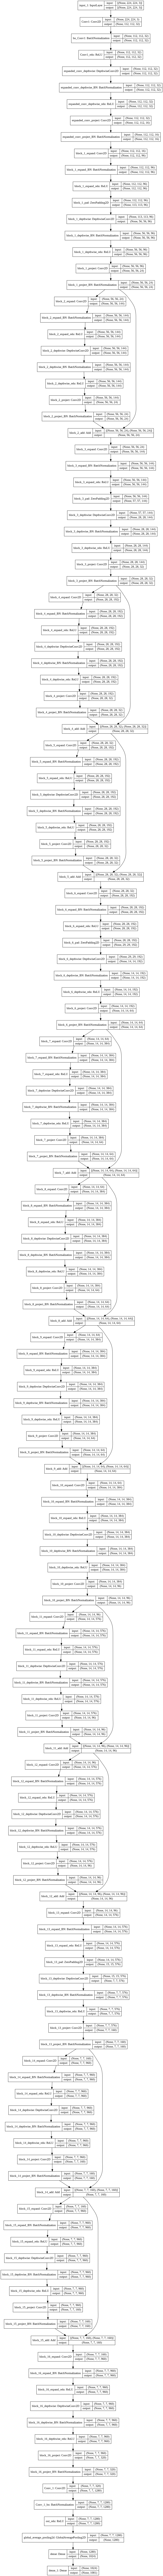

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
# Callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime 

TRAINABLE = True

try:
  TRAINABLE = True if base_model.trainable else False
except:
  pass


current_time = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
gdrive_dir = "/content/drive/MyDrive/saved_models/"
filepath = "{}plantNet_20210816{}.h5".format(gdrive_dir, "{}".format("_Trainable" if TRAINABLE else ""))

# Try loading model at filepath to continue training
# If no file exists then it creates a new one
try:
  model = keras.models.load_model(filepath)
  print("Continuing training from checkpoint")
except:
  print("No keras model found at {}, will start training from scratch.".format(filepath))
  filepath = "{0}plantNet_{1}{2}.h5".format(gdrive_dir, datetime.now().strftime('%Y%m%d'), "_Trainable" if TRAINABLE else "")
  print("New model filename is {}".format(filepath))


# Save model only when validation accuracy increases
# checkpoint = ModelCheckpoint(filepath, monitor="val_acc", verbose=1, save_best_only=True, mode="max")
checkpoint = ModelCheckpoint(filepath, save_best_only=False, save_weights_only=False)

# Tensorboard callback
logdir = gdrive_dir + "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Stop training model if validation loss does not improve for 3 epochs
earlyStopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

callbacks_list = [checkpoint, earlyStopping, tensorboard_callback]

Continuing training from checkpoint


In [ ]:
gdrive_dir + "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

'/content/drive/MyDrive/saved_models/logs/20210817-194042'

## Train Model

In [ ]:
epochs = 5
steps_per_epoch = None
# val_dataset = None
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=callbacks_list, steps_per_epoch=steps_per_epoch)



/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
7623/7623 [==============================] - 5240s 687ms/step - loss: 1.8698 - accuracy: 0.5908 - val_loss: 3.2839 - val_accuracy: 0.3974
Epoch 2/5
7623/7623 [==============================] - 5250s 689ms/step - loss: 1.8532 - accuracy: 0.5942 - val_loss: 3.1133 - val_accuracy: 0.4295
Epoch 3/5
6054/7623 [======================>.......] - ETA: 16:58 - loss: 1.8560 - accuracy: 0.5929

In [ ]:
!ls

drive  plantnet_300K  sample_data
